In [ ]:
#!pip install transformers
!pip install tweet-preprocessor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
import pandas as pd
import preprocessor as p
import nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tweet_preprocessor-0.6.0-py3-none-any.whl (27 kB)


In [ ]:
import io
uploaded = files.upload()

Saving all-threads.csv to all-threads.csv


In [ ]:
pheme = pd.read_csv("all-threads.csv")
#pheme.drop(columns=pheme.columns[0], axis=1, inplace=True)
pheme.head(4)

,Unnamed: 0,rid,created_at,cleaned_text,followers,retweets,favourited,label
0,0,552783667052167168,07 Jan 2015 11:07:51,france people dead shooting hq satirical weekl...,129573,486,38,1
1,1,552783745565347840,07 Jan 2015 11:08:09,ten killed shooting headquarters french satiri...,529882,127,15,1
2,2,552784168849907712,07 Jan 2015 11:09:50,breaking dead shooting headquarters french sat...,499741,105,15,1
3,3,552784526955806720,07 Jan 2015 11:11:16,reuters people shot dead headquarters french s...,1377384,412,32,1


In [ ]:
false_rumour = []
false_rumour_label = []
false_rumour_followers = []
false_rumour_retweets = []
false_rumour_favourited = []

true_rumour = []
true_rumour_label = []
true_rumour_followers = []
true_rumour_retweets = []
true_rumour_favourited = []

non_rumour = []
non_rumour_label = []
non_rumour_followers = []
non_rumour_retweets = []
non_rumour_favourited = []


unverified_rumour = []
unverified_rumour_label = []
unverified_rumour_followers = []
unverified_rumour_retweets = []
unverified_rumour_favourited = []


p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)

for i in range(pheme.shape[0]):#6425
  #print(pheme['Labels'][i])
  if pheme['label'][i] == '0':
    false_rumour.append(p.clean(pheme['cleaned_text'][i]))
    false_rumour_label.append(0)
 
  
  elif pheme['label'][i] == '1':
    true_rumour.append(p.clean(pheme['cleaned_text'][i]))
    true_rumour_label.append(1)



  elif pheme['label'][i] == '2':
    non_rumour.append(p.clean(pheme['cleaned_text'][i]))
    non_rumour_label.append(2)

  elif pheme['label'][i] == '3':
    unverified_rumour.append(p.clean(pheme['cleaned_text'][i]))
    unverified_rumour_label.append(3)

print(len(false_rumour)*0.8,len(true_rumour)*0.8,len(non_rumour)*0.8,len(unverified_rumour)*0.8)
print(len(false_rumour)+len(true_rumour)+len(non_rumour)+len(unverified_rumour)) #one data point is labeled None so it will be the length of the dataset - 1

508.8 852.0 3214.4 556.8000000000001
6415


In [ ]:
tweets = np.concatenate((false_rumour[:510],true_rumour[:853],non_rumour[:3217],unverified_rumour[:557]))
labels = np.concatenate((false_rumour_label[:510],true_rumour_label[:853],non_rumour_label[:3217],unverified_rumour_label[:557]))

#tweets = false_rumour
#labels = false_rumour_label
print(tweets)
print(len(tweets)*0.8*0.8)

['cartoonist stephane charbonnier critically injured attack lefigaro charliehebdo httptcofhmfumqffo'
 'cartoonists cabu charb died attack charliehebdo lepoint reports httptconbdm0iziq4 httptcoxmcxkb8qtk'
 'lepoint charliehebdo cartoonists charb amp cabu dead httptco7usd83cqd2 httptcowghblilfox'
 ...
 'whos daddy one explanation putins absence year old girlfriend checked swiss maternity unit httptcoln7dqqn8z6'
 'update girl putin cc russianmarket httptcotxbcd81g1c httptcop1epnnz2yn'
 'russian president vladimir putin ousted coup rumours swirl illhealth httptcohhf7ufn5py']
3287.6800000000003


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)

In [ ]:
!pip install transformers
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer (vocabulary)
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_bert_embeddings(tokens_tensor, model):
    segments_ids = [1]*len(tokens_tensor)
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)

    token_vecs_sum = []

    for token in token_embeddings:

        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec.clone().detach())


    return torch.stack(token_vecs_sum)

X_train_embeddings = []
for tweet in range(len(X_train)):
  encoded_dict = tokenizer.encode_plus(
                  X_train[tweet],                      
                  add_special_tokens = True, 
                  max_length = 64,  
                  truncation = True,         
                  pad_to_max_length = True,
                  return_attention_mask = True,   
                  return_tensors = 'pt',     
              ) 
  X_train_embeddings.append(get_bert_embeddings(encoded_dict['input_ids'], model))

X_test_embeddings = []
for tweet in range(len(X_test)):
  encoded_dict = tokenizer.encode_plus(
                  X_test[tweet],                      
                  add_special_tokens = True, 
                  truncation = True,
                  max_length = 64,           
                  pad_to_max_length = True,
                  return_attention_mask = True,   
                  return_tensors = 'pt',     
              ) 
  X_test_embeddings.append(get_bert_embeddings(encoded_dict['input_ids'], model))

X_train_embeddings = torch.stack(X_train_embeddings)
X_test_embeddings = torch.stack(X_test_embeddings)
print(X_train_embeddings.shape)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.7 MB/s eta 0:00:00


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


torch.Size([4109, 64, 768])


In [ ]:
print(X_train_embeddings[0][:].shape)
train_features = X_train_embeddings.view(4109, -1)
test_features = X_test_embeddings.view(1028, -1)
print(X_train_embeddings.shape)
print(train_features.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([64, 768])
torch.Size([4109, 64, 768])
torch.Size([4109, 49152])
torch.Size([4109])
torch.Size([1028])


torch.Size([4109, 64, 768])


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7052369093670229 0.7079655097761202 0.7217898832684825


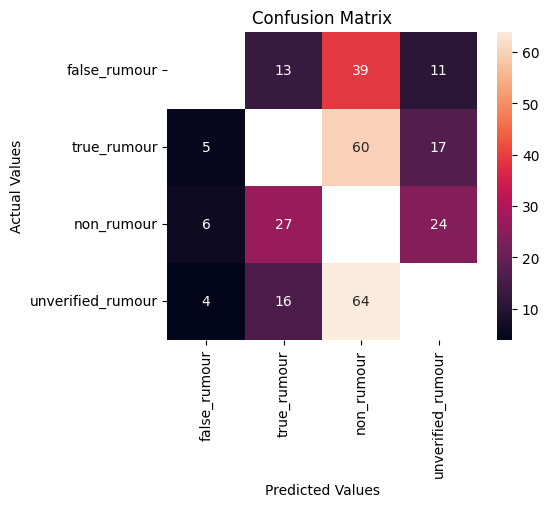

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(X_train_embeddings.shape)
model = LogisticRegression(penalty = 'l2', solver='lbfgs',max_iter=100, random_state=42)
model.fit(train_features,y_train)
y_pred = model.predict(test_features)
accuracy = f1_score(y_test, y_pred,average = 'weighted')
precision = precision_score(y_test, y_pred,average = 'weighted')
recall = recall_score(y_test, y_pred,average = 'weighted')
print(accuracy,precision,recall)

cm = confusion_matrix(y_test,y_pred)

group_names = ['false_rumour','true_rumour','non_rumour','unverified_rumour']
cm_df = pd.DataFrame(cm,
                     index = group_names, 
                     columns = group_names)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
off_diag_mask = np.eye(*cm_df.shape, dtype=bool)
sns.heatmap(cm_df, annot=True, mask=off_diag_mask,fmt='')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()